In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

<font size=3 color='darkblue'>Canny Edge Detector

canny edge detection is done is 5 steps
1. Noise Reduction
2. Gradient Calculation
3. non-max supression
4. Double threshold and edge tracking

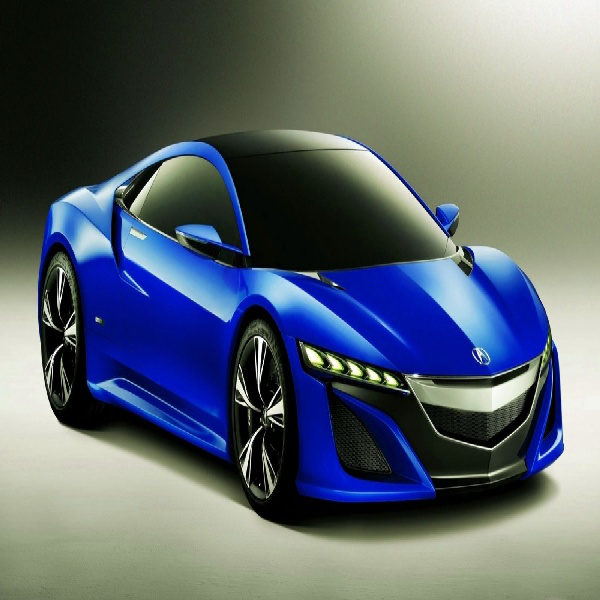

In [2]:
image = cv2.imread("images/resized_car.jpg")
Image.open("images/resized_car.jpg")

1. Noise Reduction

In [3]:
def gaussian_filter(image, filter_size, sigma):
    return cv2.GaussianBlur(image, (filter_size, filter_size), sigma)

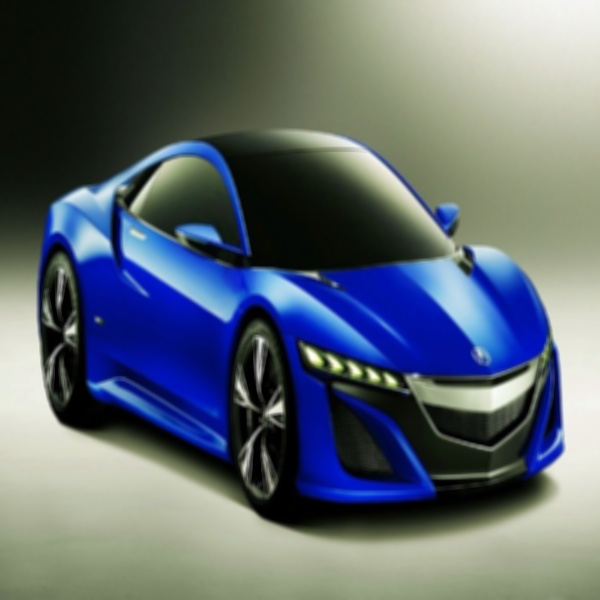

In [4]:
gaussian_img = gaussian_filter(image,5,5)
cv2.imwrite("images/Gaussian_img.jpg", gaussian_img)
Image.open("images/Gaussian_img.jpg")

2. Gradient Calulation

In [5]:
def sobel_operator(image):
    if len(image.shape)==3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    vertical_filter = np.array([[-1,0,1],
                                [-2,0,2],
                                [-1,0,1]])
    horizontal_filter = vertical_filter.transpose()
    vertical_filtered = cv2.filter2D(image, -1, vertical_filter)
    horizontal_filtered = cv2.filter2D(image, -1, horizontal_filter)
    abs_grad_x = cv2.convertScaleAbs(vertical_filtered)
    abs_grad_y = cv2.convertScaleAbs(horizontal_filtered)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    theta = np.rad2deg(np.arctan2(abs_grad_y, abs_grad_x))
    grad = grad.astype('uint8')
    return grad, theta

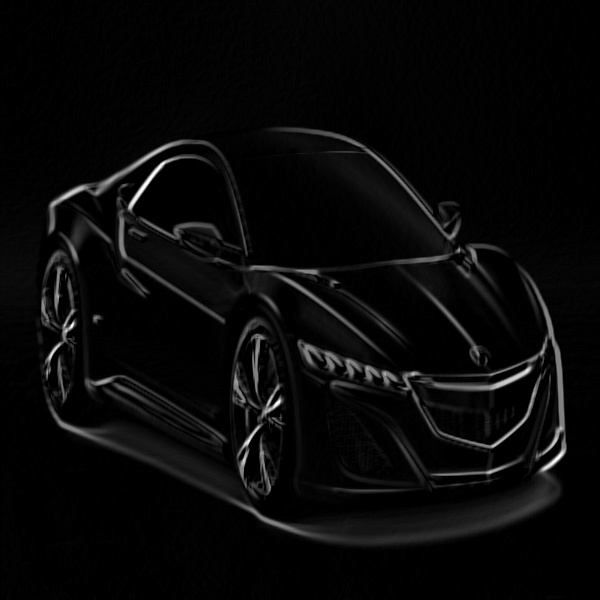

In [6]:
sobel_filtered, theta = sobel_operator(gaussian_img)
cv2.imwrite("images/sobel_img.jpg", sobel_filtered)
Image.open("images/sobel_img.jpg")

3. Non-max Supression

In [7]:
def non_max_supression(image, angles):
    size = image.shape
    supressed_edges = np.zeros(size)
    for row in range(1,size[0]-1):
        for col in range(1,size[1]-1):
            #for horizontal line
            if (0<=angles[row,col]<22.5) or (157.5<=angles[row,col]<=180):
                value = max(image[row,col-1],image[row,col+1])
            elif (22.5<=angles[row,col]<67.5):
                value = max(image[row-1,col-1], image[row+1,col+1])
            elif(67.5<=angles[row,col]<112.5):
                value = max(image[row-1,col], image[row+1,col])
            else:
                value = max(image[row+1,col-1], image[row-1, col+1])
                
            if image[row,col]>=value:
                supressed_edges[row,col] = image[row,col]
    
    supressed_edges = np.multiply(supressed_edges, 255.0/supressed_edges.max())
    return supressed_edges

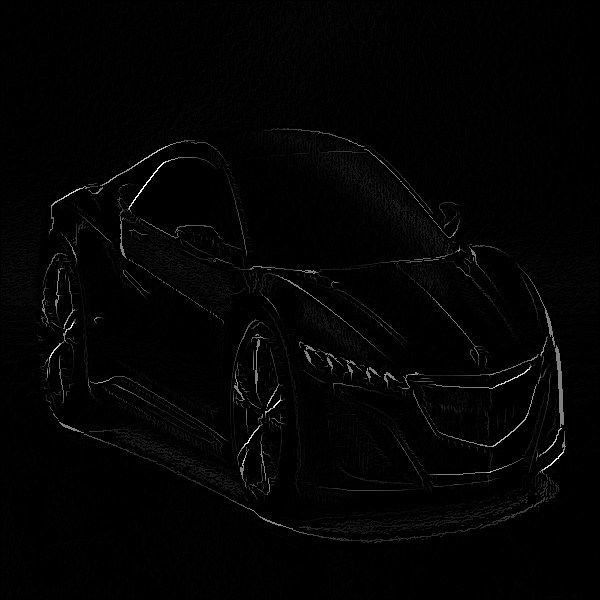

In [8]:
nmx_matrix = non_max_supression(sobel_filtered, theta)
cv2.imwrite("images/nmx_img.jpg", nmx_matrix)
Image.open("images/nmx_img.jpg")

4. Double threshold and edge tracking(hystersis)

In [9]:
def double_thresholding_hystersis(image):
    low=0
    high=50
    weak=50
    strong=255
    size = image.shape
    result = np.zeros(size)
    weak_x, weak_y = np.where((image>low)&(image<high))
    strong_x, strong_y = np.where(image>=high)
    result[weak_x, weak_y] = weak
    result[strong_x, strong_y] = strong
    dx = np.array((-1,-1,0,1,1,1,0,-1))
    dy = np.array((0,1,1,1,0,-1,-1,-1))
    
    while len(strong_x):
        x = strong_x[0]
        y = strong_y[0]
        
        strong_x = np.delete(strong_x,0)
        strong_y = np.delete(strong_y,0)
        for direction in range(len(dx)):
            new_x = x + dx[direction]
            new_y = y + dy[direction]
            if ((new_x>=0&new_x<size[0])&(new_y>=0&new_y<size[1])) and result[new_x,new_y]==weak:
                result[new_x,new_y] = strong
                np.append(strong_x,new_x)
                np.append(strong_y,new_y)
    result[result != strong] = 0
    return result

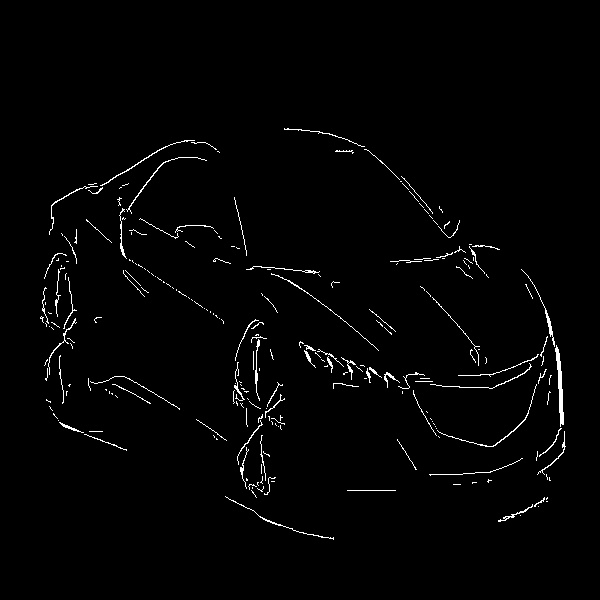

In [10]:
dbl_thres_hyst = double_thresholding_hystersis(nmx_matrix)
cv2.imwrite("images/canny_edge_img.jpg", dbl_thres_hyst)
Image.open("images/canny_edge_img.jpg")